In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
np.random.seed(1337)
import pandas as pd

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/content/drive/MyDrive/input/best_model.h5
/content/drive/MyDrive/input/brainnn.h5
/content/drive/MyDrive/input/Training/glioma_tumor/gg (552).jpg
/content/drive/MyDrive/input/Training/glioma_tumor/gg (517).jpg
/content/drive/MyDrive/input/Training/glioma_tumor/gg (29).jpg
/content/drive/MyDrive/input/Training/glioma_tumor/gg (268).jpg
/content/drive/MyDrive/input/Training/glioma_tumor/gg (627).jpg
/content/drive/MyDrive/input/Training/glioma_tumor/gg (293).jpg
/content/drive/MyDrive/input/Training/glioma_tumor/gg (417).jpg
/content/drive/MyDrive/input/Training/glioma_tumor/gg (437).jpg
/content/drive/MyDrive/input/Training/glioma_tumor/gg (251).jpg
/content/drive/MyDrive/input/Training/glioma_tumor/gg (46).jpg
/content/drive/MyDrive/input/Training/glioma_tumor/gg (436).jpg
/content/drive/MyDrive/input/Training/glioma_tumor/gg (375).jpg
/content/drive/MyDrive/input/Training/glioma_tumor/gg (526).jpg
/content/drive/MyDrive/input/Training/glioma_tumor/gg (157).jpg
/content/drive/MyDrive/

# Importing Libraries

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import PIL
import pathlib
import cv2
from tensorflow.keras import layers
from sklearn.model_selection import KFold, StratifiedKFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import glob
import csv
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [ ]:
print(tf.__version__)

2.12.0


# Preparing dataset

In [ ]:
path_test = '/content/drive/MyDrive/input/testing/Testing'
path_data = '/content/drive/MyDrive/input/Training'


path_test = pathlib.Path(path_test)
path_data = pathlib.Path(path_data)
print(path_data)

image_count = len(list(path_data.glob('*/*.jpg')))
print(image_count)
test_image_count = len(list(path_test.glob('*/*.jpg')))
print(test_image_count)

/content/drive/MyDrive/input/Training
2870
394


#### Image of a brain with tumor

/content/drive/MyDrive/input/Training/glioma_tumor/gg (517).jpg


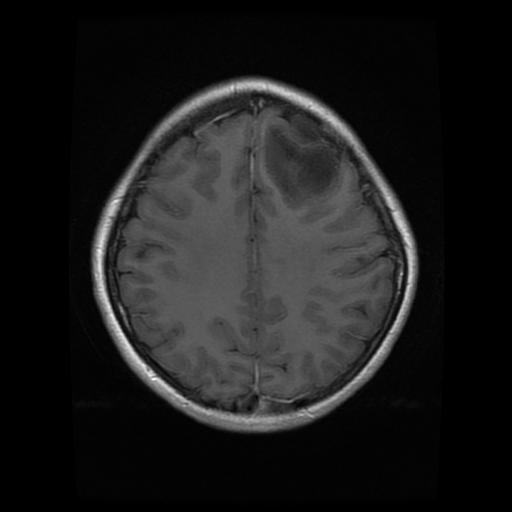

In [ ]:
tumors = list(path_data.glob('glioma_tumor/*'))
print(tumors[1])
img1 = PIL.Image.open(str(tumors[0]))
img1

#### Image of a brain with no tumor

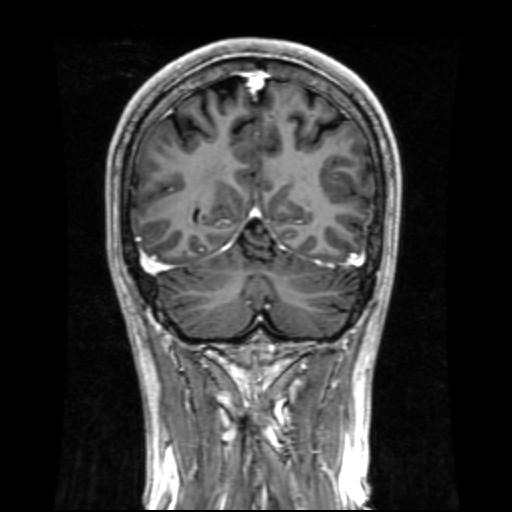

In [ ]:
not_tumors = list(path_data.glob('no_tumor/*'))
img2 = PIL.Image.open(str(not_tumors[0]))
img2

In [ ]:
img_opencv = cv2.imread(str(not_tumors[0]))
print(img_opencv.shape)
img_opencv1 = cv2.imread(str(tumors[0]))
print(img_opencv1.shape)

(512, 512, 3)
(512, 512, 3)


### Creating Testing Validation and Testing Sets

In [ ]:
batch = 32
img_height = 250
img_width = 250

In [ ]:
train = tf.keras.preprocessing.image_dataset_from_directory(
path_data,
validation_split = 0.2,
subset = 'training',
seed = 42,
image_size  =(img_height,img_width),
batch_size = batch)

Found 2870 files belonging to 4 classes.
Using 2296 files for training.


In [ ]:
val = tf.keras.preprocessing.image_dataset_from_directory(
path_data,
validation_split = 0.2,
subset = 'validation',
seed = 42,
image_size = (img_height,img_width),
batch_size = batch)

Found 2870 files belonging to 4 classes.
Using 574 files for validation.


In [ ]:
test = tf.keras.preprocessing.image_dataset_from_directory(
path_test,
seed = 42,
image_size = (img_height,img_width),
batch_size = batch)

Found 394 files belonging to 4 classes.


In [ ]:
print(train.class_names)
print(val.class_names)
print(test.class_names)

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


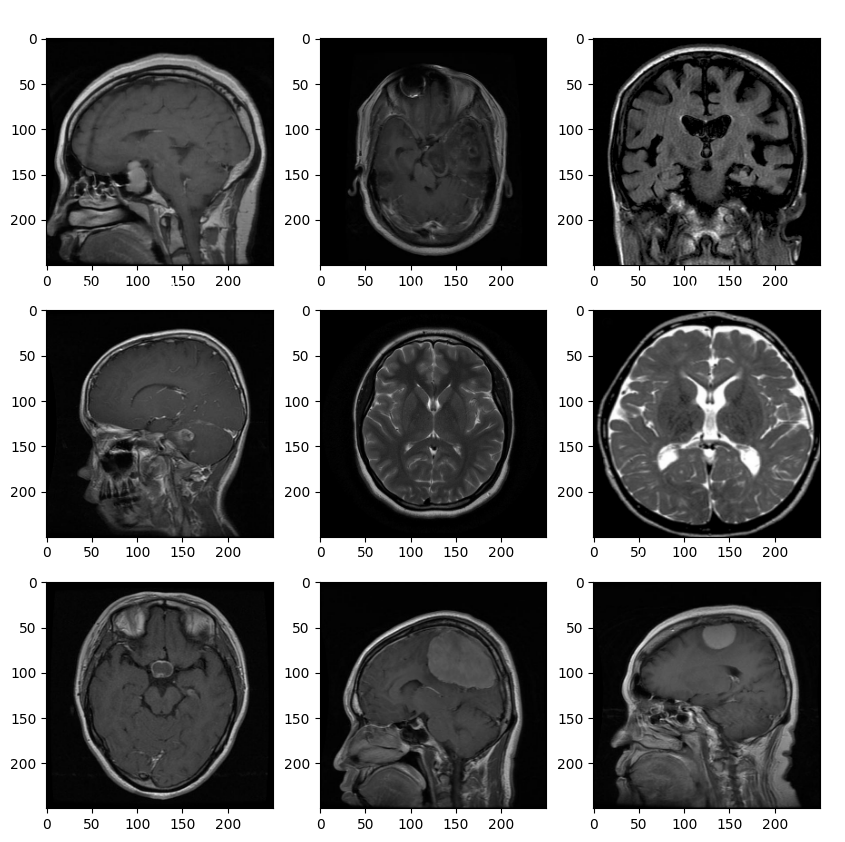

In [ ]:
classes = train.class_names
plt.figure(figsize = (10,10))
for img,label in train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(img[i].numpy().astype("uint8"))
        plt.title(classes[label[i]],
                  fontdict = {'fontsize': '19',
                              'color': 'white'}
                 )


In [ ]:
for image_batch, labels_batch in train:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 250, 250, 3)
(32,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train = train.prefetch(buffer_size=AUTOTUNE)
val = val.prefetch(buffer_size=AUTOTUNE)
test = test.prefetch(buffer_size=AUTOTUNE)

In [ ]:
help(test.as_numpy_iterator())

Help on _NumpyIterator in module tensorflow.python.data.ops.dataset_ops object:

class _NumpyIterator(builtins.object)
 |  _NumpyIterator(dataset)
 |  
 |  Iterator over a dataset with elements converted to numpy.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, dataset)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __iter__(self)
 |  
 |  __next__(self)
 |  
 |  next(self)



# Helper Functions
<a id='helper'></a>
<a id ='compare'></a>

In [ ]:
def test_tumor(list_test_path,model):
    for path_name in list_test_path:
        test_img_path = path_name


        test_image = tf.keras.preprocessing.image.load_img(
            test_img_path, target_size=(img_height, img_width)
        )
        test_array = tf.keras.preprocessing.image.img_to_array(test_image)
        test_array = tf.expand_dims(test_array, 0) # Create a batch

        predictions = model.predict(test_array)
        score = tf.nn.softmax(predictions[0])

        print(
            "This image most likely belongs to {} with a {:.2f} percent confidence."
            .format(classes[np.argmax(score)], 100 * np.max(score))
        )

In [ ]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
conv_layer_32 = tf.keras.layers.Conv2D(32,(3,3),activation='relu')
conv_layer_64 = tf.keras.layers.Conv2D(64,3,activation='relu')
conv_layer_16 = tf.keras.layers.Conv2D(16,3,activation='relu')
max_pool = tf.keras.layers.MaxPooling2D()
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

In [ ]:
data_augmentation = tf.keras.Sequential(
  [
    normalization_layer,
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

### Checking effects of the data augmentation

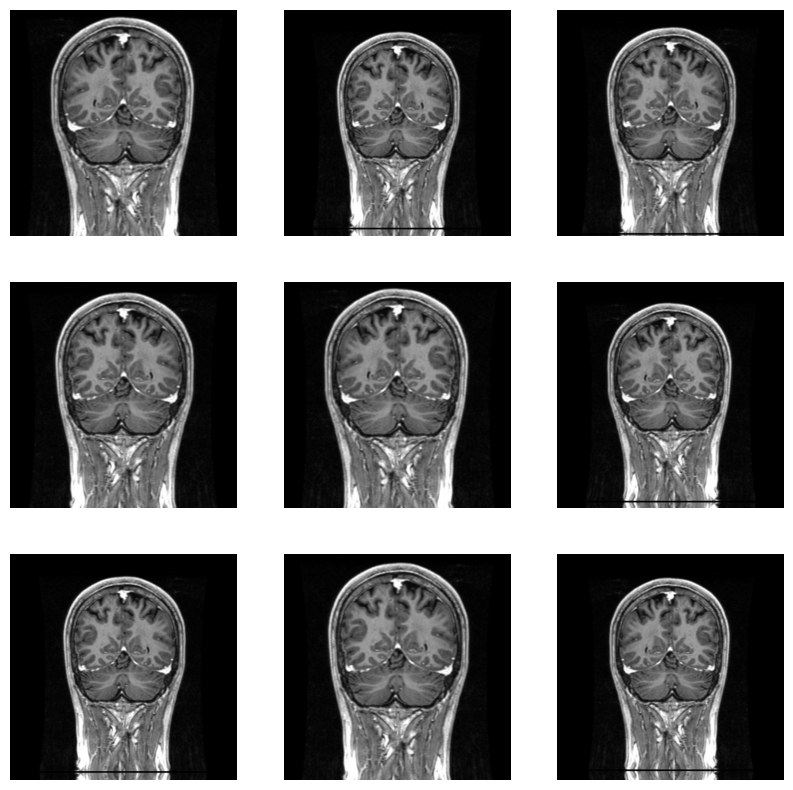

In [ ]:
plt.figure(figsize=(10, 10))
img_array = tf.keras.preprocessing.image.img_to_array(img_opencv)
img_array = tf.expand_dims(img_array,0)
for i in range(9):
  augmented_image = data_augmentation(img_array)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

# first model
<a id = 'second_model'></a>

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
# This callback will save the best weight
checkpoint=ModelCheckpoint(
    '/content/drive/MyDrive/test brain/brain2model.h5',monitor='val_loss',mode='min',
    save_weight_only=True,save_best_only=True,verbose=1
)
num_classes = 4

model2 = tf.keras.Sequential([
  normalization_layer,
  conv_layer_32,
  layers.MaxPooling2D(pool_size=(2,2)),
  conv_layer_32,
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Flatten(),
  layers.Dense(32, activation='relu'),
  layers.Dropout(0.25),
  layers.Dense(num_classes,activation='softmax')
])

In [ ]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs = 10
history = model2.fit(
  train,
  validation_data=val,
  epochs=epochs,
   callbacks = checkpoint,

)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


72/72 [==============================] - ETA: 0s - loss: 1.3412 - accuracy: 0.4721
Epoch 1: val_loss improved from inf to 0.98507, saving model to /content/drive/MyDrive/test brain/brain2model.h5
72/72 [==============================] - 16s 135ms/step - loss: 1.3412 - accuracy: 0.4721 - val_loss: 0.9851 - val_accuracy: 0.5645
Epoch 2/10
72/72 [==============================] - ETA: 0s - loss: 0.9537 - accuracy: 0.5732
Epoch 2: val_loss improved from 0.98507 to 0.72973, saving model to /content/drive/MyDrive/test brain/brain2model.h5
72/72 [==============================] - 11s 149ms/step - loss: 0.9537 - accuracy: 0.5732 - val_loss: 0.7297 - val_accuracy: 0.7195
Epoch 3/10
71/72 [============================>.] - ETA: 0s - loss: 0.7561 - accuracy: 0.6835
Epoch 3: val_loss improved from 0.72973 to 0.60401, saving model to /content/drive/MyDrive/test brain/brain2model.h5
72/72 [==============================] - 10s 133ms/step - loss: 0.7589 - accuracy: 0.6829 - val_loss: 0.6040 - val_acc

In [ ]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       multiple                  0         
                                                                 
 conv2d (Conv2D)             (None, 248, 248, 32)      896       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 124, 124, 32)     0         
 2D)                                                             
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 123008)            0         
                                                                 
 dense (Dense)               (None, 32)               

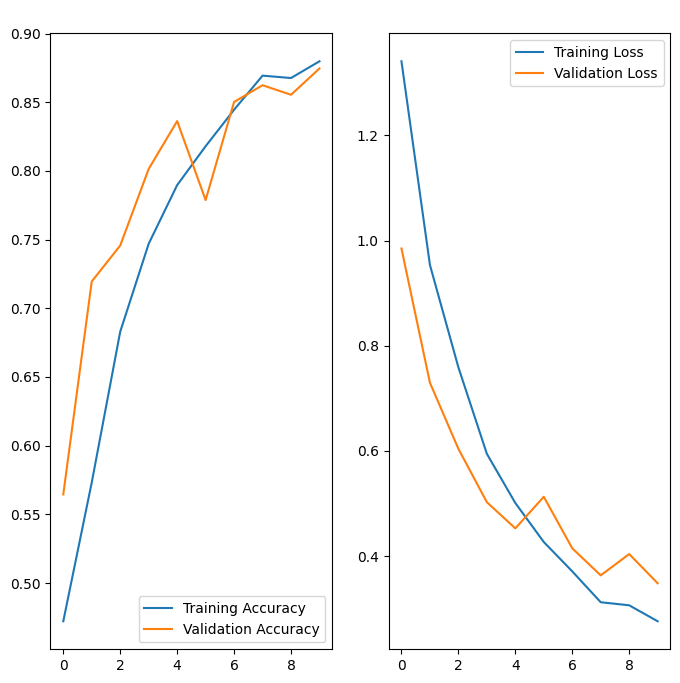

In [ ]:
eff_epochs = len(history.history['loss'])
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = 10

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(eff_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy',fontdict = {'fontsize': '14',
                              'color': 'white'})

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss',fontdict = {'fontsize': '14',
                              'color': 'white'})
plt.show()

In [ ]:
results = model2.evaluate(test)
print("test loss, test acc:", results)

13/13 [==============================] - 114s 2s/step - loss: 1.8259 - accuracy: 0.6015
test loss, test acc: [1.8259153366088867, 0.6015228629112244]


In [ ]:
list_of_paths = ['/content/drive/MyDrive/input/testing/Testing/glioma_tumor/image(1).jpg',

                ]
test_tumor(list_of_paths,model2)

1/1 [==============================] - 0s 257ms/step
This image most likely belongs to no_tumor with a 35.43 percent confidence.


# second_model

### Using a pretrained model: MobileNetV2
<a id = 'third_model'></a>

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
image_size = (img_width,img_height)
IMG_SHAPE = image_size + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

9406464/9406464 [==============================] - 1s 0us/step


In [ ]:
image_batch, label_batch = next(iter(train))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 8, 8, 1280)


In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 125, 125, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 125, 125, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(4)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 4)


In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
help(preprocess_input)

Help on function preprocess_input in module keras.applications.mobilenet_v2:

preprocess_input(x, data_format=None)
    Preprocesses a tensor or Numpy array encoding a batch of images.
    
    Usage example with `applications.MobileNet`:
    
    ```python
    i = tf.keras.layers.Input([None, None, 3], dtype = tf.uint8)
    x = tf.cast(i, tf.float32)
    x = tf.keras.applications.mobilenet.preprocess_input(x)
    core = tf.keras.applications.MobileNet()
    x = core(x)
    model = tf.keras.Model(inputs=[i], outputs=[x])
    
    image = tf.image.decode_png(tf.io.read_file('file.png'))
    result = model(image)
    ```
    
    Args:
      x: A floating point `numpy.array` or a `tf.Tensor`, 3D or 4D with 3 color
        channels, with values in the range [0, 255].
        The preprocessed data are written over the input data
        if the data types are compatible. To avoid this
        behaviour, `numpy.copy(x)` can be used.
      data_format: Optional data format of the image tensor

In [ ]:

from tensorflow.keras.callbacks import ModelCheckpoint
# This callback will save the best weight
checkpoint=ModelCheckpoint(
    '/content/drive/MyDrive/test brain/brain3model.h5',monitor='val_loss',mode='min',
    save_weight_only=True,save_best_only=True,verbose=1)
inputs = tf.keras.Input(shape=(250, 250, 3))
#x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1280,activation='relu')(x)
outputs = prediction_layer(x)
model3 = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model3.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
len(model3.trainable_variables)

4

In [ ]:
initial_epochs = 10

loss0, accuracy0 = model3.evaluate(val)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

18/18 [==============================] - 5s 101ms/step - loss: 1.4614 - accuracy: 0.2178
initial loss: 1.46
initial accuracy: 0.22


In [ ]:
history_base = model3.fit(train,
                         epochs=initial_epochs,
                         validation_data=val,
                         shuffle=False,
                          callbacks = checkpoint
                        )

Epoch 1/10
72/72 [==============================] - ETA: 0s - loss: 0.8251 - accuracy: 0.7282
Epoch 1: val_loss improved from inf to 0.48175, saving model to /content/drive/MyDrive/test brain/brain3model.h5
72/72 [==============================] - 16s 166ms/step - loss: 0.8251 - accuracy: 0.7282 - val_loss: 0.4818 - val_accuracy: 0.8275
Epoch 2/10
71/72 [============================>.] - ETA: 0s - loss: 0.3659 - accuracy: 0.8644
Epoch 2: val_loss improved from 0.48175 to 0.36097, saving model to /content/drive/MyDrive/test brain/brain3model.h5
72/72 [==============================] - 10s 125ms/step - loss: 0.3659 - accuracy: 0.8645 - val_loss: 0.3610 - val_accuracy: 0.8589
Epoch 3/10
71/72 [============================>.] - ETA: 0s - loss: 0.3003 - accuracy: 0.8794
Epoch 3: val_loss did not improve from 0.36097
72/72 [==============================] - 10s 135ms/step - loss: 0.2999 - accuracy: 0.8794 - val_loss: 0.4510 - val_accuracy: 0.8258
Epoch 4/10
71/72 [===========================

In [ ]:
model3.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 250, 250, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 250, 250, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

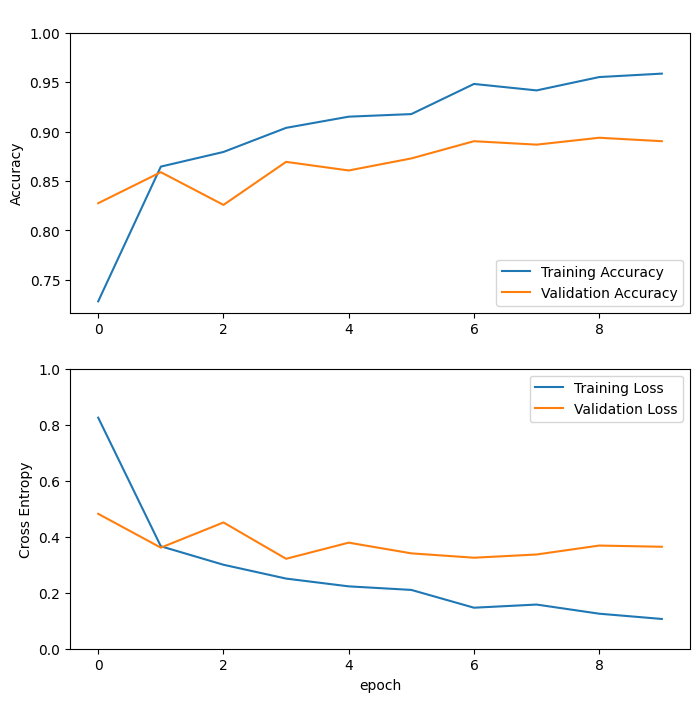

In [ ]:
acc = history_base.history['accuracy']
val_acc = history_base.history['val_accuracy']

loss = history_base.history['loss']
val_loss = history_base.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy',fontdict = {'fontsize': '14',
                              'color': 'white'})

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')


plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss',fontdict = {'fontsize': '14',
                              'color': 'white'})
plt.xlabel('epoch')
plt.show()

In [ ]:
list_of_paths = ['/content/drive/MyDrive/input/testing/Testing/meningioma_tumor/image(10).jpg',

                ]
test_tumor(list_of_paths,model3)

1/1 [==============================] - 0s 25ms/step
This image most likely belongs to meningioma_tumor with a 99.97 percent confidence.
